In [2]:
import os
import numpy as np
from datetime import datetime as dt
import datetime
from datetime import timedelta
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sms
import csv
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn import manifold
from functools import reduce
#from sklearn.impute import KNNImputer
import secrets
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

In [2]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.2.tar.gz 2>&1
!pip install --upgrade -q gspread >/dev/null 2>&1
!pip install gspread oauth2client >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install novainstrumentation >/dev/null 2>&1
!pip install pandas_profiling >/dev/null 2>&1

In [3]:
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.2.tar.gz 2>&1

In [145]:
feature = "Durchfluss"
dates = ['16.02','18.02','26.04','28.04']
#dates = ['28.04']
list_dfs_MD = []
list_dfs_data = []
for i in range(len(dates)):
    date = dates[i]  
    orig_folder = 'C:/Users/Anni/CS/_BA/ReLkat/data/data_csv/'+date+"/"
    df_MD = pd.read_csv(os.path.join(orig_folder,"MD_"+feature+"_"+date+".csv"),index_col = 0)
    data_df = pd.read_csv(os.path.join(orig_folder,date+"_total.csv"),index_col = 0)
    list_dfs_MD.append(df_MD)
    list_dfs_data.append(data_df)
    print(date," loading MD for: ",feature," from ", date, "with number of datapoints: ",df_MD.shape[0])
df_MD_total = pd.concat(list_dfs_MD)
df_MD_total.reset_index(drop=True,inplace=True)
print("Total number of datapoints: ",df_MD_total.shape[0])
df_cycle_times = pd.concat(list_dfs_data)
df_cycle_times = df_cycle_times[["start_time","end_time","cycle_time"]]
df_cycle_times['cycle_time'] = (df_cycle_times['cycle_time']).apply(lambda x: str(x)[10:22])
df_cycle_times['cycle_time'] =  (df_cycle_times['cycle_time']).apply(lambda x: datetime.datetime.strptime(x,'%M:%S.%f'))
df_cycle_times['cycle_time'] = (df_cycle_times['cycle_time']).apply(lambda x:datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond).total_seconds())
mms = MinMaxScaler()
df_cycle_times[['cycle_time']] = mms.fit_transform(df_cycle_times[['cycle_time']])
MD = df_MD_total
MD.sort_values(by=['sys_time'],inplace=True)

16.02  loading MD for:  Durchfluss  from  16.02 with number of datapoints:  12695
18.02  loading MD for:  Durchfluss  from  18.02 with number of datapoints:  46298
26.04  loading MD for:  Durchfluss  from  26.04 with number of datapoints:  68940
28.04  loading MD for:  Durchfluss  from  28.04 with number of datapoints:  133651
Total number of datapoints:  261584


In [40]:
pd.set_option('display.max_rows', 700)
start_time = '2021-02-16 11:55:05.876769333'
end_time = '2021-04-28 18:01:48.559682659'
MD.drop(['uuid','plc_time','sequence_number','value_string','value_bytes','identifier'],axis=1,inplace=True)
MD['start_cycle'] = np.datetime64('NaT')
MD['end_cycle'] = np.datetime64('NaT')
MD['end_cycle'] = np.where((MD['label'].str.contains('Taktzeit 1 Start '))&(MD['value_bool']==False),MD['sys_time'],np.datetime64('NaT'))
MD.loc[(MD['value_bool']==True),"start_cycle"] = MD['sys_time']
MD = MD[(MD['sys_time']>= start_time)&(MD['sys_time']<= end_time)]
MD.sort_values(by=['sys_time'],inplace=True)
MD.reset_index(drop=True,inplace=True)
print(MD.shape)

# MD['sys_time'] = MD['sys_time'].astype('datetime64[s]')

(261583, 7)


<ipython-input-40-42660eeaec05>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MD.sort_values(by=['sys_time'],inplace=True)


In [41]:
MD['cycle'] = MD['value_bool'][~MD['start_cycle'].isnull()]*np.array([i for i in range(MD['start_cycle'].nunique())])
MD['cycle'].fillna(method='ffill',inplace=True)

MD = MD[~((MD['cycle']==3)|(MD['cycle']==4))]
MD.reset_index(drop=True,inplace=True)
MD['cycle'] = MD['value_bool'][~MD['start_cycle'].isnull()]*np.array([i for i in range(MD['start_cycle'].nunique())])
MD['cycle'].fillna(method='ffill',inplace=True)
MD.sort_values(by=['sys_time'],inplace=True)
#grouped = MD.groupby('cycle').size()    #agg('count')    #filter(lambda x: x['Count'].min()>8 )
#grouped

<ipython-input-41-557effaf9b77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MD['cycle'] = MD['value_bool'][~MD['start_cycle'].isnull()]*np.array([i for i in range(MD['start_cycle'].nunique())])
C:\Users\Anni\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [53]:
MD[1300:1400]

,sys_time,value_integer,value_double,value_bool,label,start_cycle,end_cycle,cycle
1300,2021-02-16 12:02:20.292373939,NaN,39.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1301,2021-02-16 12:02:20.352413678,NaN,40.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1302,2021-02-16 12:02:20.472548694,NaN,41.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1303,2021-02-16 12:02:27.046676180,NaN,40.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1304,2021-02-16 12:02:27.122456071,NaN,39.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1305,2021-02-16 12:02:27.167304501,NaN,38.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1306,2021-02-16 12:02:27.227407913,NaN,37.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1307,2021-02-16 12:02:27.291854056,NaN,36.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1308,2021-02-16 12:02:27.397112351,NaN,37.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2
1309,2021-02-16 12:02:27.517007441,NaN,38.000000,NaN,Kühlschmierstoff: Durchfluss ND Vorlauf in l/...,NaT,None,2


In [52]:
# check nr. of cycles and their length
#print(MD['cycle'].nunique())
#MD['cycle'].value_counts()

In [37]:
# check start index of cycles
#MD['value_bool'][~MD['start_cycle'].isnull()]*np.array([i for i in range(MD['start_cycle'].nunique())])

In [54]:
features = list(MD['label'].unique())[1:]
features

['Kühlschmierstoff: Durchfluss ND Vorlauf  in l/min (DB_PROZESSWERTE.iw_450_93 )',
 'Kühlschmierstoff: Durchfluss HD Vorlauf in l/min (DB_PROZESSWERTE.iw_450_92 )']

In [55]:
df_features = []
for feature in features:
    df_feature = MD[MD['label']==feature][['sys_time','value_integer','value_double']]
    df_feature[feature] = np.where(df_feature['value_integer'].isnull(),df_feature['value_double'],df_feature['value_integer'])
    df_feature.drop(['value_integer','value_double'],axis=1,inplace=True)
    df_features.append(df_feature)

In [56]:
df_MD = reduce(lambda left,right: pd.merge(left,right,on=['sys_time'],how='outer'), df_features)
df_MD.sort_values(by=['sys_time'],inplace=True)
df_MD.reset_index(drop=True,inplace=True)

In [57]:
df_MD.head()

,sys_time,Kühlschmierstoff: Durchfluss ND Vorlauf in l/min (DB_PROZESSWERTE.iw_450_93 ),Kühlschmierstoff: Durchfluss HD Vorlauf in l/min (DB_PROZESSWERTE.iw_450_92 )
0,2021-02-16 11:55:06.416670285,1.0,NaN
1,2021-02-16 11:55:06.431654429,2.0,NaN
2,2021-02-16 11:55:06.461913834,3.0,NaN
3,2021-02-16 11:55:06.482242402,4.0,NaN
4,2021-02-16 11:55:06.511932771,5.0,NaN


In [58]:
# Load times of start and end for all the cycles from existing df
dates = ['16.02','18.02','26.04','28.04']
list_dfs = []
max_length = 0
for i in range(len(dates)):
    date = dates[i]
    orig_folder = 'C:/Users/Anni/CS/_BA/Relkat/data/data_csv/'+date+"/"
    data_df = pd.read_csv(os.path.join(orig_folder,date+"_total.csv"),index_col = 0)
    data_df = data_df[["start_time","end_time"]]
    list_dfs.append(data_df)
    print(date," loading data from ", date, "with number of datapoints: ",data_df.shape)    
df_total = pd.concat(list_dfs)
df_total.reset_index(drop=True,inplace=True)
print(df_total.shape)
start_cycle = np.array(df_total['start_time'])
end_cycle = np.array(df_total['end_time'])

16.02  loading data from  16.02 with number of datapoints:  (6, 2)
18.02  loading data from  18.02 with number of datapoints:  (27, 2)
26.04  loading data from  26.04 with number of datapoints:  (27, 2)
28.04  loading data from  28.04 with number of datapoints:  (84, 2)
(144, 2)


In [59]:
end_cycle[0]

'2021-02-16 12:17:25.032056134'

In [60]:
len(end_cycle)

144

In [61]:
print(df_MD.shape)
df_MD.loc[0,'Kühlschmierstoff: Durchfluss HD Vorlauf in l/min (DB_PROZESSWERTE.iw_450_92 )']=0
df_MD.fillna(method='ffill',inplace=True)
MD.sort_values(by=['sys_time'],inplace=True)
#df_MD.head(100)

(236563, 3)


In [62]:
df_MD.head()

,sys_time,Kühlschmierstoff: Durchfluss ND Vorlauf in l/min (DB_PROZESSWERTE.iw_450_93 ),Kühlschmierstoff: Durchfluss HD Vorlauf in l/min (DB_PROZESSWERTE.iw_450_92 )
0,2021-02-16 11:55:06.416670285,1.0,0.0
1,2021-02-16 11:55:06.431654429,2.0,0.0
2,2021-02-16 11:55:06.461913834,3.0,0.0
3,2021-02-16 11:55:06.482242402,4.0,0.0
4,2021-02-16 11:55:06.511932771,5.0,0.0


In [63]:
df_ND = df_MD.drop(['Kühlschmierstoff: Durchfluss HD Vorlauf in l/min (DB_PROZESSWERTE.iw_450_92 )'],axis=1)
df_HD = df_MD.drop(['Kühlschmierstoff: Durchfluss ND Vorlauf  in l/min (DB_PROZESSWERTE.iw_450_93 )'], axis=1)

In [144]:
df = df_ND
df_cycles = []
feature = 'Kühlschmierstoff: Durchfluss ND Vorlauf  in l/min (DB_PROZESSWERTE.iw_450_93 )'
feature_name = 'DF_KSS_ND'
max_len = 0

for i in range(len(start_cycle)):
    feat_cycle = np.array(df[(df['sys_time']>=start_cycle[i])&(df['sys_time']<=end_cycle[i])][feature])    
       
    if(len(feat_cycle) > max_len):        
        max_len = len(feat_cycle)

    df_cycles.append(feat_cycle)#.reshape(len(feat_cycle),1))
print(max_len)
print('_______________') 
for i in range(len(df_cycles)):
    ar = df_cycles[i]
    pad_len = max_len - ar.shape[0]
    pad_ar = np.pad(ar, ((0), (pad_len)), 'constant', constant_values=(0))    
    df_cycles[i] = pad_ar
ar_total = np.vstack(df_cycles)
print(ar_total.shape)
n_com = 3
pca = decomposition.PCA(n_components=n_com)
ar_total_PCA = pca.fit_transform(ar_total) 
ar_total_PCA.shape
mms = MinMaxScaler()
ar_total_PCA = mms.fit_transform(ar_total_PCA)
print(pca.explained_variance_ratio_)

1714
_______________
(144, 1714)
[0.26352901 0.14454627 0.07485458]


In [142]:
dest_folder = "C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/"
filename = "ar_PCA_"+feature_name+"_"+str(n_com)
np.save(os.path.join(dest_folder,filename)+".npy", ar_total_PCA)
print(os.path.join(dest_folder,filename)+".npy")

C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/ar_PCA_DF_KSS_HD_3.npy


In [143]:
print(pca.explained_variance_ratio_)

[0.39787931 0.21926345 0.1225675 ]


In [133]:

# df['_energy_PCA_c1_prev'] = en_PCA_3[:,0]
# df['_energy_PCA_c2_prev'] = en_PCA_3[:,1]
# df['_energy_PCA_c3_prev'] = en_PCA_3[:,2] 

In [62]:
# Make sure array has time series of equal length for every cycle
ar_DF_KSS_HD = np.vstack(df_HD_cycles)
ar_DF_KSS_HD.shape[0]/1300

144.0

In [64]:
# define number of datapoints that are used - starting from the end of the time series
df_ND_cycles = []
min_len = 800

for i in range(len(start_cycle)):
    ND_cycle = df_ND[(df_ND['sys_time']>=start_cycle[i])&(df_ND['sys_time']<=end_cycle[i])].drop('sys_time',axis=1).values
    
    #print(len(ND_cycle))
    
    if(len(ND_cycle) > min_len):
        ND_cycle = ND_cycle[-min_len:]
        #print(ND_cycle.shape)
    else:
        pad_len = min_len - len(ND_cycle)
        ND_cycle = np.pad(ND_cycle.reshape(len(ND_cycle),), (pad_len,0), 'constant', constant_values=(0))
        #print(ND_cycle.shape)
    df_ND_cycles.append(ND_cycle.reshape(len(ND_cycle),1))
    #print('_______________')      

In [65]:
# Make sure array has time series of equal length for every cycle
ar_DF_KSS_ND = np.vstack(df_ND_cycles)
ar_DF_KSS_ND.shape[0]/800

144.0

In [46]:
feature = 'DF_KSS_HD'
ar = ar_DF_KSS_HD

dest_folder = "C:/Users/Anni/CS/_sig_crun/ReLkat/data/total/MD_feature_arrays/"
filename = "ar_"+feature
np.save(os.path.join(dest_folder,filename)+".npy", ar)
print(os.path.join(dest_folder,filename)+".npy")

C:/Users/Anni/CS/_sig_crun/ReLkat/data/total/MD_feature_arrays/ar_DF_KSS_HD.npy


In [66]:
def create_feat_array(feat_name,ar,window_size):
    cfg_file_stat = tsfel.get_features_by_domain('statistical')                                         
    ar_feat_stat = tsfel.time_series_features_extractor(cfg_file_stat, ar, window_size=window_size)
    
    # Remove highly correlated features
    corr_features = tsfel.correlated_features(ar_feat_stat)
    ar_feat_stat.drop(corr_features, axis=1, inplace=True)
    
    # Remove low variance features
    selector = VarianceThreshold()
    ar_feat_stat = selector.fit_transform(ar_feat_stat)
    print(ar_feat_stat.shape) 
    
    # Normalize Features
    scaler = preprocessing.StandardScaler()
    ar_feat_stat_norm = scaler.fit_transform(ar_feat_stat)


    cfg_file_temp = tsfel.get_features_by_domain('temporal')                                         
    ar_feat_temp = tsfel.time_series_features_extractor(cfg_file_temp, ar, window_size=window_size)
    corr_features = tsfel.correlated_features(ar_feat_temp)
    ar_feat_temp.drop(corr_features, axis=1, inplace=True)
    selector = VarianceThreshold()
    ar_feat_temp = selector.fit_transform(ar_feat_temp)
    print(ar_feat_temp.shape) 
    scaler = preprocessing.StandardScaler()
    ar_feat_temp_norm = scaler.fit_transform(ar_feat_temp)
    ar_feat_total_norm = np.concatenate([ar_feat_stat_norm,ar_feat_temp_norm],axis=1)
    print(ar_feat_total_norm.shape)

    return ar_feat_total_norm

In [ ]:
ar_KSS_HD_feat_total_norm = create_feat_array("DF_KSS_HD",ar_DF_KSS_ND,1300)
ar_KSS_ND_feat_total_norm = create_feat_array("DF_KSS_ND",ar_DF_KSS_ND,800)

Text(0.5, 1.0, 'Kühlschmierstoff: Durchfluss ND Vorlauf in l/min')

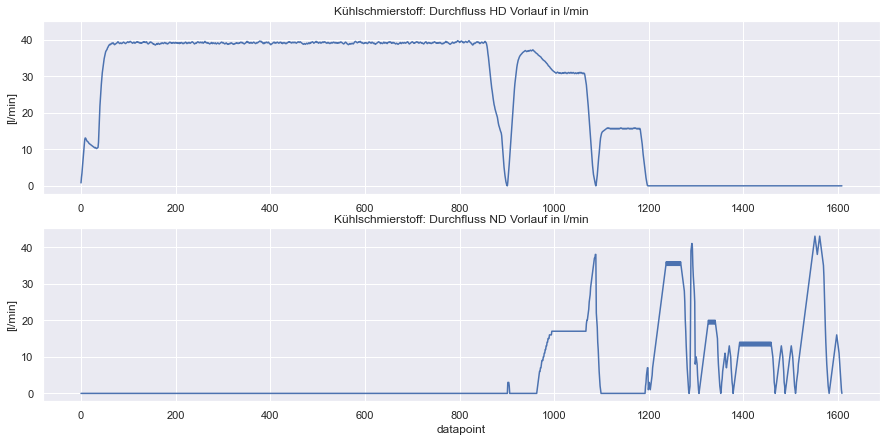

In [74]:
%matplotlib inline
fig = plt.figure(figsize=(15,7))
ax1 = plt.subplot(2,1,1)
plt_size = 10
plt.plot(DF_HD)
plt.ylabel("[l/min]")
plt.title("Kühlschmierstoff: Durchfluss HD Vorlauf in l/min")

ax2 = plt.subplot(2,1,2,sharey = ax1)
plt_size = 10
plt.plot(DF_ND)
plt.xlabel("datapoint")
plt.ylabel("[l/min]")
plt.title("Kühlschmierstoff: Durchfluss ND Vorlauf in l/min")

In [ ]:
cfg_file = tsfel.get_features_by_domain()                                                        # If no argument is passed retrieves all available features
X_train = tsfel.time_series_features_extractor(cfg_file, X_train_sig, fs=50, window_size=250) 

In [59]:
len(df_MD)/81

1528.5802469135801

In [109]:
#df_MD = reduce(lambda left,right: pd.merge(left,right,on=['sys_time'],how='outer'), df_features)
df_MD = pd.merge(df_features[0],df_features[1], on='sys_time',how='outer')

In [112]:
df_MD['Temperatur_Differenz_Kühlaggregat_Vorlauf_Rücklauf in °C'] = df_MD['Kühlaggregat: Themperatur Rücklauf Maschine in °C (DB_PROZESSWERTE.iw_130_92 )'] - df_MD['Kühlaggregat: Themperatur Vorlauf Maschine in °C (DB_PROZESSWERTE.iw_130_91 )']

In [120]:
df_MD['Temperatur_Differenz_Kühlaggregat_Vorlauf_Rücklauf in °C'].mean()

1.0812209432192985

In [121]:
df_MD.head()

,sys_time,Kühlaggregat: Themperatur Vorlauf Maschine in °C (DB_PROZESSWERTE.iw_130_91 ),Kühlaggregat: Themperatur Rücklauf Maschine in °C (DB_PROZESSWERTE.iw_130_92 ),Temperatur_Differenz_Kühlaggregat_Vorlauf_Rücklauf in °C
0,2021-02-16 11:02:51,21.9,22.05843,0.15843
1,2021-02-16 11:02:52,22.0,22.05843,0.05843
2,2021-02-16 11:02:53,22.0,22.05843,0.05843
3,2021-02-16 11:02:54,22.0,22.05843,0.05843
4,2021-02-16 11:02:55,22.0,22.05843,0.05843


In [122]:
list(zip(df_data_total['start_time'],df_data_total['end_time']))[0][0]

'2021-02-16 12:11:28.597212487'

In [123]:
df_data_total.head(3)

,start_time,end_time,cycle_time,Hyd,KSS,KSS_HD,Hyd_prev,KSS_prev,KSS_HD_prev,_PCA_c1_prev,_PCA_c2_prev,_PCA_c3_prev,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev,energy_total
0,2021-02-16 12:11:28.597212487,2021-02-16 12:17:25.032056134,0.971215,0.95,0.54,0.82,0.95,0.54,0.82,1.000000,0.00000,0.205657,0.197993,41.546290,51.984535,387.016873,85.665913,1.000000
1,2021-02-16 12:24:29.191695783,2021-02-16 12:30:21.562330841,0.923848,0.85,0.42,0.66,0.95,0.54,0.82,1.000000,0.00000,0.205657,49.292741,95.148314,64.065409,107.445383,-30.499430,0.875905
2,2021-02-16 12:30:21.572206169,2021-02-16 12:35:37.867297790,0.503399,0.80,0.36,0.58,0.85,0.42,0.66,0.978515,0.07031,0.201065,37.480967,19.632414,118.367259,90.923220,-35.693121,0.422215


In [124]:
list_max = []
list_mean = []
derived_features = ['max_diff_temp_VL_RL','mean_diff_temp_VL_RL']
list_df_feat = ['Temperatur_Differenz_Kühlaggregat_Vorlauf_Rücklauf in °C']
keys = list(zip(df_data_total['start_time'],df_data_total['end_time']))
for k in range(len(keys)):        
    feat_max,feat_mean = np.array(df_MD[(df_MD['sys_time']>=keys[k][0])&(df_MD['sys_time']<=keys[k][1])] [list_df_feat[0]]).max(),\
                         np.array(df_MD[(df_MD['sys_time']>=keys[k][0])&(df_MD['sys_time']<=keys[k][1])] [list_df_feat[0]]).mean()
    list_max.append(feat_max)
    list_mean.append(feat_mean)
df_data_total[derived_features[0]] = np.array(list_max)
df_data_total[derived_features[1]] = np.array(list_mean)

In [125]:
pd.set_option('display.max_rows', 1000)
df_data_total

,start_time,end_time,cycle_time,Hyd,KSS,KSS_HD,Hyd_prev,KSS_prev,KSS_HD_prev,_PCA_c1_prev,_PCA_c2_prev,_PCA_c3_prev,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev,energy_total,max_diff_temp_VL_RL,mean_diff_temp_VL_RL
0,2021-02-16 12:11:28.597212487,2021-02-16 12:17:25.032056134,0.971215,0.95,0.54,0.82,0.95,0.54,0.82,1.000000,0.000000,0.205657,0.197993,41.546290,51.984535,387.016873,85.665913,1.000000,2.050000,0.172408
1,2021-02-16 12:24:29.191695783,2021-02-16 12:30:21.562330841,0.923848,0.85,0.42,0.66,0.95,0.54,0.82,1.000000,0.000000,0.205657,49.292741,95.148314,64.065409,107.445383,-30.499430,0.875905,1.500000,0.563211
2,2021-02-16 12:30:21.572206169,2021-02-16 12:35:37.867297790,0.503399,0.80,0.36,0.58,0.85,0.42,0.66,0.978515,0.070310,0.201065,37.480967,19.632414,118.367259,90.923220,-35.693121,0.422215,1.500000,0.552427
3,2021-02-16 12:35:37.882486211,2021-02-16 12:40:59.597300611,0.566564,0.75,0.30,0.50,0.80,0.36,0.58,0.352426,0.870746,0.563447,-71.005961,44.615660,-34.698414,322.055795,-104.287936,0.529804,1.600000,0.269462
4,2021-02-16 12:40:59.612345957,2021-02-16 12:46:56.332045172,0.974535,0.70,0.24,0.42,0.75,0.30,0.50,0.616398,0.942249,0.391824,35.292160,72.769550,7.642250,130.007208,-52.233073,0.619594,1.600000,0.881233
5,2021-02-16 12:46:56.346928509,2021-02-16 12:52:55.251583295,1.000000,0.65,0.18,0.34,0.70,0.24,0.42,0.923604,0.101744,0.321450,-86.179730,9.858143,-26.479062,962.682017,323.190288,0.686777,1.700001,0.826880
6,2021-02-18 14:11:51.457233443,2021-02-18 14:16:55.727043257,0.363248,1.00,0.60,0.90,0.65,0.18,0.34,0.964645,0.011465,0.446542,-101.573345,-80.988800,4.220927,93.248978,-76.616228,0.514051,2.600000,2.141776
7,2021-02-18 14:16:55.742135711,2021-02-18 14:21:59.377971201,0.355859,1.00,0.60,0.90,1.00,0.60,0.90,0.099334,0.408090,0.179870,240.216610,-52.767202,-91.521669,-2.992453,-152.672787,0.607509,2.600000,1.754002
8,2021-02-18 14:21:59.392349658,2021-02-18 14:27:03.332804979,0.359410,1.00,0.60,0.90,1.00,0.60,0.90,0.002632,0.405332,0.126769,249.858957,-68.791248,-95.393807,50.181251,-139.593042,0.561792,2.600000,1.201096
9,2021-02-18 14:27:03.347869424,2021-02-18 14:32:07.302039716,0.359569,0.95,0.54,0.82,1.00,0.60,0.90,0.085152,0.458887,0.150140,232.224049,-58.256371,-74.731194,18.080379,-154.941952,0.519820,2.700001,2.098739


In [164]:
machine data only fully known during the next cycle
for d_f in range(len(derived_features)):
    df_data_total[derived_features[d_f]] = df_data_total[derived_features[d_f]].shift(periods=1)

In [163]:
# replace missing data in first row
imputer = KNNImputer(n_neighbors=3)
df_data_total[derived_features[0]] = imputer.fit_transform(np.array(df_data_total)[:,-2:])[:,0]
df_data_total[derived_features[1]] = imputer.fit_transform(np.array(df_data_total)[:,-2:])[:,1]
df_data_total.head()

,start_time,end_time,cycle_time,Hyd,KSS,KSS_HD,Hyd_prev,KSS_prev,KSS_HD_prev,_PCA_c1_prev,_PCA_c2_prev,_PCA_c3_prev,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev,energy_total,max_diff_temp_VL_RL,mean_diff_temp_VL_RL
0,2021-02-16 12:11:28.597212487,2021-02-16 12:17:25.032056134,0.971215,0.95,0.54,0.82,0.95,0.54,0.82,1.000000,0.000000,0.205657,0.197993,41.546290,51.984535,387.016873,85.665913,1.000000,1.884966,0.750529
1,2021-02-16 12:24:29.191695783,2021-02-16 12:30:21.562330841,0.923848,0.85,0.42,0.66,0.95,0.54,0.82,1.000000,0.000000,0.205657,49.292741,95.148314,64.065409,107.445383,-30.499430,0.875905,2.050000,0.172408
2,2021-02-16 12:30:21.572206169,2021-02-16 12:35:37.867297790,0.503399,0.80,0.36,0.58,0.85,0.42,0.66,0.978515,0.070310,0.201065,37.480967,19.632414,118.367259,90.923220,-35.693121,0.422215,1.500000,0.563211
3,2021-02-16 12:35:37.882486211,2021-02-16 12:40:59.597300611,0.566564,0.75,0.30,0.50,0.80,0.36,0.58,0.352426,0.870746,0.563447,-71.005961,44.615660,-34.698414,322.055795,-104.287936,0.529804,1.500000,0.552427
4,2021-02-16 12:40:59.612345957,2021-02-16 12:46:56.332045172,0.974535,0.70,0.24,0.42,0.75,0.30,0.50,0.616398,0.942249,0.391824,35.292160,72.769550,7.642250,130.007208,-52.233073,0.619594,1.600000,0.269462


In [368]:
n_com = 3
pca = decomposition.PCA(n_components=n_com)
PCA_feature = pca.fit_transform(array_total[:,:493])
df_data_total['_KSS_lmin_PCA_c1_prev'] = PCA_feature[:,0]
df_data_total['_KSS_lmin_PCA_c2_prev'] = PCA_feature[:,1]
df_data_total['_KSS_lmin_PCA_c3_prev'] = PCA_feature[:,2]
df_data_total.drop(['start_time','end_time',"cycle_time_prev"],axis=1,inplace=True)

In [369]:
n_com = 3
pca = decomposition.PCA(n_components=n_com)
PCA_feature = pca.fit_transform(array_total[:,493:])
df_data_total['_KSS_HD_lmin_PCA_c1_prev'] = PCA_feature[:,0]
df_data_total['_KSS_HD_lmin_PCA_c2_prev'] = PCA_feature[:,1]
df_data_total['_KSS_HD_lmin_PCA_c3_prev'] = PCA_feature[:,2]

In [371]:
# replace missing data
imputer = KNNImputer(n_neighbors=3)
df_data_total.iloc[0,:] = imputer.fit_transform(np.array(df_data_total))[0,:]
df_data_total.head()

,cycle_time,Hyd,KSS,KSS_HD,Hyd_prev,KSS_prev,KSS_HD_prev,_PCA_c1_prev,_PCA_c2_prev,_PCA_c3_prev,energy_total,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev,_KSS_HD_lmin_PCA_c3_prev
0,0.971215,0.95,0.54,0.82,0.95,0.54,0.82,1.000000,0.000000,0.205657,1.000000,0.197993,41.546290,51.984535,387.016873,85.665913,-4.950835
1,0.923848,0.85,0.42,0.66,0.95,0.54,0.82,1.000000,0.000000,0.205657,0.875905,49.292741,95.148314,64.065409,107.445383,-30.499430,-118.560099
2,0.503399,0.80,0.36,0.58,0.85,0.42,0.66,0.978515,0.070310,0.201065,0.422215,37.480967,19.632414,118.367259,90.923220,-35.693121,-157.766183
3,0.566564,0.75,0.30,0.50,0.80,0.36,0.58,0.352426,0.870746,0.563447,0.529804,-71.005961,44.615660,-34.698414,322.055795,-104.287936,-102.148531
4,0.974535,0.70,0.24,0.42,0.75,0.30,0.50,0.616398,0.942249,0.391824,0.619594,35.292160,72.769550,7.642250,130.007208,-52.233073,-119.060722


In [165]:
df_data_total = df_data_total[['Hyd', 'KSS', 'KSS_HD', 'Hyd_prev', 'KSS_prev', 'KSS_HD_prev',
        '_PCA_c1_prev', '_PCA_c2_prev', '_PCA_c3_prev','_KSS_lmin_PCA_c1_prev', '_KSS_lmin_PCA_c2_prev',
        '_KSS_lmin_PCA_c3_prev', '_KSS_HD_lmin_PCA_c1_prev',
        '_KSS_HD_lmin_PCA_c2_prev','max_diff_temp_VL_RL','mean_diff_temp_VL_RL','energy_total',
 'cycle_time']]

In [166]:
df_data_total.head()

,Hyd,KSS,KSS_HD,Hyd_prev,KSS_prev,KSS_HD_prev,_PCA_c1_prev,_PCA_c2_prev,_PCA_c3_prev,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev,max_diff_temp_VL_RL,mean_diff_temp_VL_RL,energy_total,cycle_time
0,0.95,0.54,0.82,0.95,0.54,0.82,1.000000,0.000000,0.205657,0.197993,41.546290,51.984535,387.016873,85.665913,1.884966,0.750529,1.000000,0.971215
1,0.85,0.42,0.66,0.95,0.54,0.82,1.000000,0.000000,0.205657,49.292741,95.148314,64.065409,107.445383,-30.499430,2.050000,0.172408,0.875905,0.923848
2,0.80,0.36,0.58,0.85,0.42,0.66,0.978515,0.070310,0.201065,37.480967,19.632414,118.367259,90.923220,-35.693121,1.500000,0.563211,0.422215,0.503399
3,0.75,0.30,0.50,0.80,0.36,0.58,0.352426,0.870746,0.563447,-71.005961,44.615660,-34.698414,322.055795,-104.287936,1.500000,0.552427,0.529804,0.566564
4,0.70,0.24,0.42,0.75,0.30,0.50,0.616398,0.942249,0.391824,35.292160,72.769550,7.642250,130.007208,-52.233073,1.600000,0.269462,0.619594,0.974535


In [167]:
df_data_total.to_csv('C:/Users/signa/_Relkat/data/total/df_'+str(df_data_total.shape[0])+'_dp_total_temp.csv')
print('saving '+('C:/Users/signa/_Relkat/data/total/df_'+str(df_data_total.shape[0])+'_dp_total_temp.csv'))

saving C:/Users/signa/_Relkat/data/total/df_144_dp_total_temp.csv


In [192]:
# df_MD.set_index('sys_time',inplace=True)
# df_MD = df_MD.resample('s').mean()
# df_MD.reset_index(inplace=True,drop=False)

In [213]:
# MD = MD[['sys_time','cycle']]
# MD.drop_duplicates(subset='sys_time',inplace=True)
# MD.reset_index(drop=True,inplace=True)
# df_MD = pd.merge(MD,df_MD, on='sys_time',how='inner')
# df_MD.head()

In [ ]:
# fig = plt.figure(figsize=(25, 14))
# ax1 = plt.subplot(1,1,1)
# plt.xticks(np.arange(0,93,1))
# plt.plot(np.arange(len(df_data_total)),df_data_total['max_diff_temp_VL_RL'], label="Max. Differenz in °C Kühlaggregat",color='red')
# plt.plot(np.arange(len(df_data_total)),df_data_total['mean_diff_temp_VL_RL'],label="Mittlere Differenz in °C Kühlaggregat",color='orange')
# plt.legend(fontsize=20)
# ax1.set_xlabel('Takt',fontsize=20)

In [48]:
data_df = pd.read_csv("C:/Users/signa/_Relkat/data/total/df_144_dp_final_ohne_MD.csv",index_col = 0)

In [49]:
data_df.shape

(144, 17)

In [51]:
data_df

,Hyd,KSS,KSS_HD,cycle_time,energy_total,Hyd_prev,KSS_prev,KSS_HD_prev,cycle_time_prev,energy_1_prev,energy_2_prev,energy_3_prev,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev
0,0.95,0.54,0.82,0.971215,0.950000,0.54,0.82,0.82,0.971215,0.193718,1.000000,1.000000,0.197993,41.546290,51.984535,387.016873,85.665913
1,0.85,0.42,0.66,0.923848,0.875905,0.95,0.54,0.82,0.971215,0.193718,1.000000,1.000000,49.292741,95.148314,64.065409,107.445383,-30.499430
2,0.80,0.36,0.58,0.503399,0.422215,0.85,0.42,0.66,0.923848,0.307664,0.665415,0.957196,37.480967,19.632414,118.367259,90.923220,-35.693121
3,0.75,0.30,0.50,0.566564,0.529804,0.80,0.36,0.58,0.503399,0.415814,0.484376,0.455255,-71.005961,44.615660,-34.698414,322.055795,-104.287936
4,0.70,0.24,0.42,0.974535,0.619594,0.75,0.30,0.50,0.566564,0.628154,0.304461,0.534554,35.292160,72.769550,7.642250,130.007208,-52.233073
5,0.65,0.18,0.34,1.000000,0.686777,0.70,0.24,0.42,0.974535,0.000000,0.502759,0.942692,-86.179730,9.858143,-26.479062,962.682017,323.190288
6,1.00,0.60,0.90,0.363248,0.514051,0.65,0.18,0.34,1.000000,0.120338,0.497204,0.945145,-101.573345,-80.988800,4.220927,93.248978,-76.616228
7,1.00,0.60,0.90,0.355859,0.607509,1.00,0.60,0.90,0.363248,0.766794,0.519945,0.315491,240.216610,-52.767202,-91.521669,-2.992453,-152.672787
8,1.00,0.60,0.90,0.359410,0.561792,1.00,0.60,0.90,0.355859,0.915814,0.480387,0.346988,249.858957,-68.791248,-95.393807,50.181251,-139.593042
9,0.95,0.54,0.82,0.359569,0.519820,1.00,0.60,0.90,0.359410,0.733574,0.706798,0.296820,232.224049,-58.256371,-74.731194,18.080379,-154.941952


In [54]:
data_df_final = pd.read_csv("C:/Users/signa/_Relkat/data/total/df_144_dp_total_0705_en3.csv",index_col = 0)

In [55]:
data_df_final.head()

,Hyd,KSS,KSS_HD,cycle_time,energy_total,Hyd_prev,KSS_prev,KSS_HD_prev,cycle_time_prev,energy_1_prev,energy_2_prev,energy_3_prev
0,0.95,0.54,0.82,0.971215,0.950000,0.54,0.82,0.82,0.971215,0.193718,1.000000,1.000000
1,0.85,0.42,0.66,0.923848,0.875905,0.95,0.54,0.82,0.971215,0.193718,1.000000,1.000000
2,0.80,0.36,0.58,0.503399,0.422215,0.85,0.42,0.66,0.923848,0.307664,0.665415,0.957196
3,0.75,0.30,0.50,0.566564,0.529804,0.80,0.36,0.58,0.503399,0.415814,0.484376,0.455255
4,0.70,0.24,0.42,0.974535,0.619594,0.75,0.30,0.50,0.566564,0.628154,0.304461,0.534554


In [56]:
data_df_final.shape

(144, 12)

In [59]:
data_df_final = pd.read_csv("C:/Users/signa/_Relkat/data/total/total_Relkat_xb.csv",index_col = 0)

In [60]:
data_df_final.head()

,flow,flow2,flow3,_Hyd_prev,_KSS_prev,KSS_HD_prev,_PCA_c1_prev,_PCA_c2_prev,_PCA_c3_prev,_KSS_lmin_PCA_c1_prev,_KSS_lmin_PCA_c2_prev,_KSS_lmin_PCA_c3_prev,_KSS_HD_lmin_PCA_c1_prev,_KSS_HD_lmin_PCA_c2_prev,1_in,2_in,_energy_prev,_cycle_time_prev
0,0.95,0.54,0.82,0.95,0.54,0.82,1.000000,0.000000,0.205657,0.197993,41.546290,51.984535,387.016873,85.665913,1.000000,0.971215,0.119324,0.370627
1,0.85,0.42,0.66,0.95,0.54,0.82,1.000000,0.000000,0.205657,49.292741,95.148314,64.065409,107.445383,-30.499430,0.875905,0.923848,1.000000,0.971215
2,0.80,0.36,0.58,0.85,0.42,0.66,0.978515,0.070310,0.201065,37.480967,19.632414,118.367259,90.923220,-35.693121,0.422215,0.503399,0.875905,0.923848
3,0.75,0.30,0.50,0.80,0.36,0.58,0.352426,0.870746,0.563447,-71.005961,44.615660,-34.698414,322.055795,-104.287936,0.529804,0.566564,0.422215,0.503399
4,0.70,0.24,0.42,0.75,0.30,0.50,0.616398,0.942249,0.391824,35.292160,72.769550,7.642250,130.007208,-52.233073,0.619594,0.974535,0.529804,0.566564
